# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


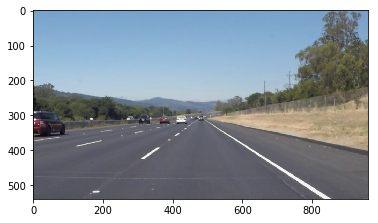

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [608]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    TODO: Find the slope in the four sets of coords, (x1-y2) ex. ((y2-y1)/(x2-x1))
                 if the slope is <0, it must relate to the right lane, and >0, left lane

    """
    #left lane line
    x_left = []
    y_left = []

    #right lane line
    x_right = []
    y_right = []

     #top and bottom of lane
    y_top = 320
    y_bottom = 500

     #slopes
    left_slope = []
    right_slope = []

    #find which lines are left/right lanes related
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if slope > 0:
                x_right.extend((x1, x2))
                y_right.extend((y1, y2))
                right_slope.append(slope)
            else:
                x_left.extend((x1, x2))
                y_left.extend((y1, y2))
                left_slope.append(slope)

    #gather means
    mean_left_slope = np.mean(left_slope)
    mean_right_slope = np.mean(right_slope)
    #mean of left coords
    mean_x_left = np.mean(x_left)
    mean_y_left = np.mean(y_left)
    #mean of right coords
    mean_x_right = np.mean(x_right)
    mean_y_right = np.mean(y_right)


    #x = (-b/m) + y // solve for x intercept, y = 0
    try:
        x_left_intercept_top = int((-y_top) / mean_left_slope)
        x_right_intercept_top = int((y_top) / mean_right_slope)

        x_left_intercept_bottom = int((-y_bottom) / mean_left_slope)
        print('--> ', x_left_intercept_bottom)
        x_right_intercept_bottom = int((y_bottom) / mean_right_slope)

        pairs = [[x_left_intercept_top, y_top, x_left_intercept_bottom, y_bottom],[
                x_right_intercept_bottom, y_bottom, x_right_intercept_top, y_top]]

        for x1, y1, x2, y2 in pairs:
            print(x1, y1, x2, y2)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    except Exception as e:
        print('Nan')
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [609]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

-->  619
396 320 619 500
977 500 625 320
-->  770
493 320 770 500
823 500 526 320
-->  709
454 320 709 500
959 500 614 320
-->  636
407 320 636 500
851 500 544 320
-->  688
440 320 688 500
773 500 495 320
-->  678
434 320 678 500
936 500 599 320


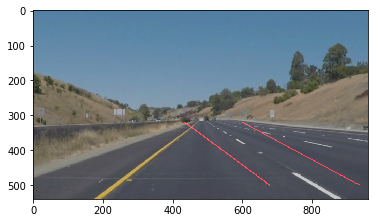

In [611]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

image = mpimg.imread('test_images/solidWhiteCurve.jpg')

def detect_lanes(image):
    # grayscale() image
    gray = grayscale(image)

    #kernel sizes and gaussian_blur() it
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # thresholds, note 1:2, or 1:3 ratio is best
    low_threshold = 50
    high_threshold = 150

    #mark your edge with canny()
    edges = canny(blur_gray, low_threshold, high_threshold)

    #mask the image edges
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    #create a polygon with region_of_interest()
    imshape = image.shape
    #y = 540
    #x = 960
    #                       x .  y .    x .  y .    x .  y .     x . y
#     vertices = np.array([[(150, 540), (400, 320), (500, 320), (900, 540)]], dtype=np.int32)
    vertices = np.array([[(100,imshape[0]), (440, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_image = region_of_interest(edges, vertices)

    #Hough it
    rho = 1
    theta = np.pi/260
    threshold = 1
    min_line_length = 10
    max_line_gap = 4
    line_image = np.copy(image) * 0

    masked_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    #color the edges
    color_edges = np.dstack((edges, edges, edges))

    #draw the lines on the image
    lines_edges = weighted_img(masked_image, image)
    plt.imshow(lines_edges)
    return lines_edges


image_sample_set = os.listdir("test_images/")
for img_label in image_sample_set:
    image = mpimg.imread("test_images/" + img_label)
    img = detect_lanes(image)
    mpimg.imsave("test_images_output/" + img_label, img)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [612]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [613]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = detect_lanes(image)

    return result

Let's try the one with the solid white lane on the right first ...

-->  681
436 320 681 500
813 500 520 320
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  3%|▎         | 4/126 [00:00<00:03, 33.24it/s]

-->  681
436 320 681 500
813 500 520 320
-->  662
423 320 662 500
862 500 551 320
-->  673
431 320 673 500
860 500 550 320
-->  688
440 320 688 500
827 500 529 320
-->  0
0 320 0 500
850 500 544 320
-->  783
501 320 783 500
844 500 540 320
-->  630
403 320 630 500
818 500 523 320


--> 


  6%|▋         | 8/126 [00:00<00:03, 33.60it/s]

 758
485 320 758 500
824 500 527 320
-->  708
453 320 708 500
845 500 540 320
-->  679
435 320 679 500
813 500 520 320
-->  661
423 320 661 500
788 500 504 320



 10%|▉         | 12/126 [00:00<00:03, 32.62it/s]

-->  682
436 320 682 500
816 500 522 320
-->  716
458 320 716 500
868 500 555 320
-->  691
442 320 691 500
805 500 515 320


-->  711
455 320 711 500
814 500 521 320



 13%|█▎        | 16/126 [00:00<00:03, 32.16it/s]

-->  921
589 320 921 500
804 500 514 320
-->  729
466 320 729 500
766 500 490 320
-->  733
469 320 733 500
763 500 488 320



 16%|█▌        | 20/126 [00:00<00:03, 32.81it/s]

-->  675
432 320 675 500
801 500 513 320
-->  713
456 320 713 500
809 500 518 320
-->  767
491 320 767 500
852 500 545 320
-->  763
488 320 763 500
757 500 484 320



 19%|█▉        | 24/126 [00:00<00:03, 33.79it/s]

-->  739
473 320 739 500
778 500 498 320
-->  712
455 320 712 500
802 500 513 320
-->  699
447 320 699 500
746 500 477 320
--> 


 22%|██▏       | 28/126 [00:00<00:02, 34.05it/s]

 673
431 320 673 500
831 500 531 320
-->  725
464 320 725 500
791 500 506 320
-->  725
464 320 725 500
790 500 506 320
-->  659
422 320 659 500
854 500 547 320


-->  794
508 320 794 500
776 500 496 320
-->  685
438 320 685 500
811 500 519 320
-->  776
497 320 776 500
823 500 527 320



 25%|██▌       | 32/126 [00:01<00:03, 30.52it/s]

-->  705
451 320 705 500
773 500 494 320
-->  716
458 320 716 500
779 500 498 320


 28%|██▊       | 35/126 [00:01<00:03, 25.90it/s]


-->  663
424 320 663 500
802 500 513 320
-->  665
425 320 665 500
790 500 505 320
-->  737
472 320 737 500
791 500 506 320



 30%|███       | 38/126 [00:01<00:03, 26.34it/s]

-->  625
400 320 625 500
860 500 550 320
-->  671
429 320 671 500
746 500 478 320
-->  685
438 320 685 500
816 500 522 320



 33%|███▎      | 42/126 [00:01<00:02, 28.03it/s]

-->  612
392 320 612 500
773 500 495 320
-->  672
430 320 672 500
741 500 474 320
-->  627
401 320 627 500
802 500 513 320
-->  700
448 320 700 500
769 500 492 320



 37%|███▋      | 46/126 [00:01<00:02, 29.17it/s]

-->  725
464 320 725 500
818 500 523 320
-->  635
406 320 635 500
770 500 493 320
-->  673
430 320 673 500
785 500 502 320



 40%|███▉      | 50/126 [00:01<00:02, 29.91it/s]

-->  670
429 320 670 500
815 500 521 320
-->  674
431 320 674 500
823 500 526 320
-->  653
417 320 653 500
776 500 497 320
-->  765
489 320 765 500
816 500 522 320


-->  785
502 320 785 500
869 500 556 320
-->  692
443 320 692 500
735 500 470 320
-->  842
539 320 842 500
814 500 521 320



 43%|████▎     | 54/126 [00:01<00:02, 30.31it/s]

-->  713
456 320 713 500
784 500 501 320
-->  746
477 320 746 500
758 500 485 320
-->  701
449 320 701 500
766 500 490 320



 46%|████▌     | 58/126 [00:01<00:02, 29.61it/s]

-->  762
488 320 762 500
786 500 503 320
-->  701
448 320 701 500
774 500 495 320
-->  825
528 320 825 500
769 500 492 320


 48%|████▊     | 61/126 [00:02<00:02, 27.23it/s]

-->  685
438 320 685 500
755 500 483 320
-->  681
436 320 681 500
781 500 500 320


 51%|█████     | 64/126 [00:02<00:02, 26.47it/s]

-->  732
468 320 732 500
745 500 477 320
-->  696
445 320 696 500
753 500 482 320
-->  805
515 320 805 500
747 500 478 320
--> 

 53%|█████▎    | 67/126 [00:02<00:02, 27.18it/s]

 852
545 320 852 500
765 500 490 320
-->  744
476 320 744 500
742 500 475 320
-->  806
516 320 806 500
840 500 537 320


 56%|█████▋    | 71/126 [00:02<00:01, 28.66it/s]

-->  738
472 320 738 500
750 500 480 320
-->  743
475 320 743 500
754 500 483 320
-->  723
463 320 723 500
813 500 520 320
-->  778
497 320 778 500
754 500 482 320
-->  693
443 320 693 500
751 500 480 320


 60%|█████▉    | 75/126 [00:02<00:01, 30.13it/s]

-->  727
465 320 727 500
804 500 514 320
-->  744
476 320 744 500
794 500 508 320


 63%|██████▎   | 79/126 [00:02<00:01, 30.69it/s]

-->  714
457 320 714 500
777 500 497 320
-->  748
478 320 748 500
760 500 486 320
-->  777
497 320 777 500
745 500 477 320
-->  672
430 320 672 500
733 500 469 320
-->  1030
659 320 1030 500
814 500 521 320
-->  754
482 320 754 500
817 500 523 320
-->  749
479 320 749 500
776 500 497 320


 69%|██████▉   | 87/126 [00:02<00:01, 32.22it/s]

-->  741
474 320 741 500
724 500 463 320
-->  757
484 320 757 500
735 500 470 320
-->  771
493 320 771 500
722 500 462 320
-->  813
520 320 813 500
730 500 467 320
-->  758
485 320 758 500
731 500 468 320
-->  803
514 320 803 500
766 500 490 320
-->  729
466 320 729 500
742 500 475 320


 72%|███████▏  | 91/126 [00:02<00:01, 31.44it/s]

-->  710
454 320 710 500
730 500 467 320
-->  928
594 320 928 500
728 500 466 320
-->  882
564 320 882 500
728 500 466 320
-->  836
535 320 836 500
769 500 492 320
-->  798
511 320 798 500
738 500 472 320
-->  739
473 320 739 500
744 500 476 320


 75%|███████▌  | 95/126 [00:03<00:01, 29.81it/s]

-->  829
530 320 829 500
735 500 470 320
-->  717
458 320 717 500
741 500 474 320
-->  791
506 320 791 500
722 500 462 320
-->  738
472 320 738 500
724 500 463

 79%|███████▊  | 99/126 [00:03<00:00, 28.18it/s]

 320
-->  793
507 320 793 500
721 500 461 320


 81%|████████  | 102/126 [00:03<00:00, 25.07it/s]

-->  774
495 320 774 500
720 500 461 320
-->  869
556 320 869 500
714 500 457 320
-->  721
461 320 721 500
762 500 488 320
-->  732
468 320 732 500
735 500 471 320


 83%|████████▎ | 105/126 [00:03<00:00, 26.16it/s]

-->  682
436 320 682 500
767 500 490 320
-->  682
436 320 682 500
731 500 467 320


 87%|████████▋ | 109/126 [00:03<00:00, 28.22it/s]

-->  689
441 320 689 500
727 500 465 320
-->  740
474 320 740 500
756 500 483 320
-->  739
473 320 739 500
788 500 504 320
-->  750
480 320 750 500
757 500 484 320
-->  712
456 320 712 500
752 500 481 320


 90%|████████▉ | 113/126 [00:03<00:00, 29.77it/s]

-->  844
540 320 844 500
728 500 466 320
-->  718
460 320 718 500
738 500 472 320


 93%|█████████▎| 117/126 [00:03<00:00, 30.68it/s]

-->  735
470 320 735 500
771 500 493 320
-->  851
544 320 851 500
740 500 474 320
-->  840
538 320 840 500
743 500 475 320
-->  802
513 320 802 500
744 500 476 320
-->  743
475 320 743 500
710 500 454 320
-->  696
445 320 696 500
736 500 471 320
-->  766
490 320 766 500
794 500 508 320


 96%|█████████▌| 121/126 [00:04<00:00, 31.06it/s]

-->  759
486 320 759 500
832 500 533 320
-->  748
479 320 748 500
778 500 498 320
-->  757
484 320 757 500
798 500 511 320
-->  703
450 320 703 500
753 500 482 320
-->  820
525 320 820 500
777 500 497 320


 99%|█████████▉| 125/126 [00:04<00:00, 30.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.02 s, sys: 1.16 s, total: 5.19 s
Wall time: 4.58 s


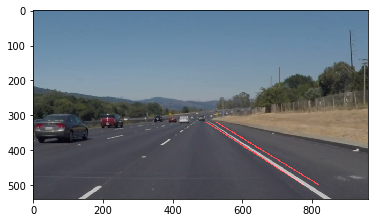

In [614]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))